### TEXT LENGTH ANALYSIS

In [1]:
import pandas as pd

from transformers import ErnieMTokenizer

from utils import compute_metrics, conf_mat, get_error_counts, run_test
from plots import conf_mat_plot, len_plot

In [2]:
model_name = 'ernie-m-large'  

### Final (silver) validation results
silver_val_df = pd.read_parquet('data/silver-annotation.parquet')

### CLS2 predicting results
cls2_prod_preds_df = pd.read_parquet(f'data/cls2-{model_name}-test-predictions.parquet')

### Length analysis parameters
cutoff = 512 # Maximum token length
len_var = 'ErnieM Token Len'


# Merge true labels and predictions
final_val = pd.merge(silver_val_df, cls2_prod_preds_df, on='EstText Index').rename(columns={'Label': 'True Label'})

In [3]:
# Tokenizing the texts to calculate token length without truncation
tokenizer = ErnieMTokenizer.from_pretrained('susnato/ernie-m-large_pytorch')

def tokenlen(text):
    tokens = tokenizer(text, add_special_tokens=True, truncation=False)  
    return len(tokens['input_ids'])

final_val[len_var] = final_val['Text'].apply(tokenlen)

final_val[len_var].describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (1257 > 514). Running this sequence through the model will result in indexing errors


count     300.000000
mean      858.920000
std       868.240777
min        39.000000
25%       270.250000
50%       552.000000
75%      1261.250000
max      8852.000000
Name: ErnieM Token Len, dtype: float64

In [4]:
final_val_shorter = final_val[final_val[len_var] <= cutoff]
final_val_longer = final_val[final_val[len_var] > cutoff]

# print('Shorter texts:')
# compute_metrics(final_val_shorter, 0)

# print('Longer texts:')
# compute_metrics(final_val_longer, 0)

Count above cutoff (512): 156 (52.0%)
Count below or equal to cutoff (512): 144 (48.0%)
Median truncated length for articles above cutoff: 715.50


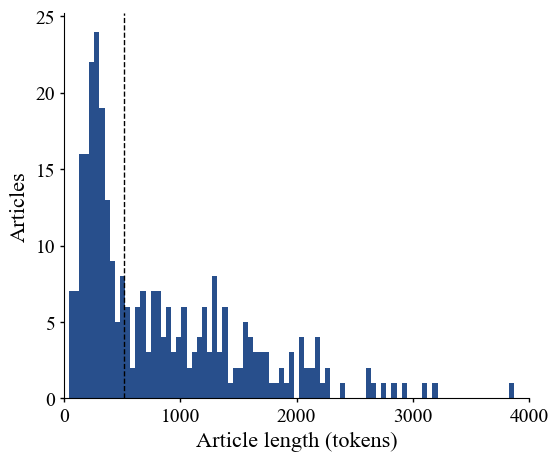

In [11]:
len_plot(final_val, len_var, cutoff, 4000, output="toklen")

In [6]:
print("Shorter articles.")
conf_mat(final_val_shorter)

print("\nLonger articles.")
conf_mat(final_val_longer)

Shorter articles.
Confusion Matrix:
                 Predicted 0    Predicted 1  
Actual 0       | 131            2              
Actual 1       | 7              4              

Longer articles.
Confusion Matrix:
                 Predicted 0    Predicted 1  
Actual 0       | 24             29             
Actual 1       | 0              103            


Testing the difference of length between classes

In [7]:
count_shorter = final_val_shorter['True Label'].value_counts()
count_longer = final_val_longer['True Label'].value_counts()

# Contingency table for actual 0s and 1s
class_table = [
    [count_shorter.get(0, 0), count_longer.get(0, 0)],  
    [count_shorter.get(1, 0), count_longer.get(1, 0)]   
]

run_test(class_table, error_type="Class Distribution")

Class Distribution: Chi-square statistic = 105.88352796279366, df = 1, p-value = 7.819894383570089e-25


Testing the difference of length in Type I and Type II errors

In [8]:
TN_shorter, FP_shorter, FN_shorter, TP_shorter = get_error_counts(final_val_shorter['True Label'], final_val_shorter['Prediction'])
TN_longer, FP_longer, FN_longer, TP_longer = get_error_counts(final_val_longer['True Label'], final_val_longer['Prediction'])

# Contingency tables for Type I and Type II errors
type_I_table = [[TN_shorter, FP_shorter], [TN_longer, FP_longer]]
type_II_table = [[FN_shorter, TP_shorter], [FN_longer, TP_longer]]

run_test(type_I_table, error_type="Type I Error")
run_test(type_II_table, error_type="Type II Error")

Type I Error: Fisher's Exact Test p-value = 3.555834014163273e-17 (no test statistic or df)
Type II Error: Fisher's Exact Test p-value = 8.020053058361259e-09 (no test statistic or df)
